# Semantic Segmentation of satellite imagery using U-Net

## Step 2: Model building


In [1]:
# Install necessary library
"!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet"
!pip install segmentation-models-pytorch --quiet

In [2]:
!pip install segmentation-models-pytorch torchmetrics albumentations --quiet

In [3]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! 🎉")

    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    # Get the name of the current GPU device
    current_gpu_name = torch.cuda.get_device_name(0)
    print(f"Current GPU Name: {current_gpu_name}")

else:
    print("CUDA is not available. Using CPU instead.")

CUDA is available! 🎉
Number of GPUs: 1
Current GPU Name: NVIDIA GeForce RTX 3070


In [4]:
# Set segmentation models to use PyTorch
import os
os.environ["SM_FRAMEWORK"] = "torch"

In [5]:
import os
import random
from pathlib import Path

import cv2
import numpy as np
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import albumentations as A  # Better augmentation for PyTorch
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torchmetrics import JaccardIndex  # IoU for PyTorch


print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(0))


CUDA Available: True
Device Count: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 3070


In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
# Define needed directory paths
dir_root = Path("../data/landcover_ai")

dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")

dir_models = Path("../data/models")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

..\data\landcover_ai\train_images\train has 2250 images.
..\data\landcover_ai\train_masks\train has 2250 images.
..\data\landcover_ai\val_images\val has 750 images.
..\data\landcover_ai\val_masks\val has 750 images.


In [9]:
print(dir_root)
print(dir_models)
print(dir_train_img)

..\data\landcover_ai
..\data\models
..\data\landcover_ai\train_images\train


In [10]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

img exists: ..\data\landcover_ai\train_images\train\M-34-65-D-a-4-4_patch_23_22.tif


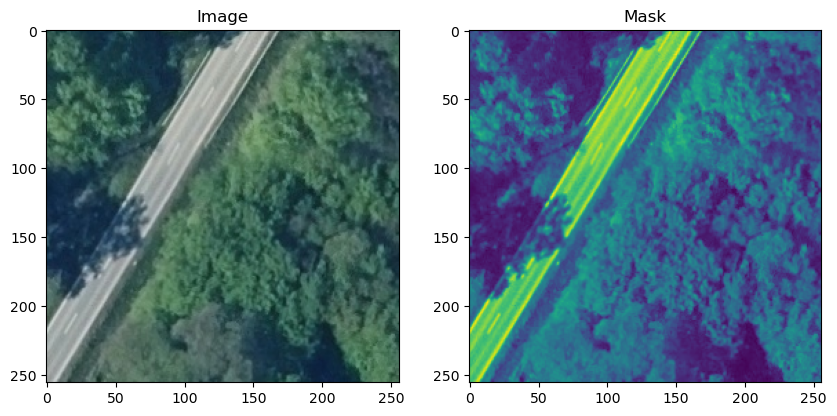

In [11]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

def plot_image_and_mask(image_path: Path, device="cuda"):
    """
    Function to plot an image alongside its mask, optimized for PyTorch and GPU.
    """
    if not image_path.exists():
        print(f"Error: Image file not found at {image_path}")
        return

    # Load and convert image
    img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error: Failed to load image {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Generate corresponding mask path
    mask_path = Path(str(image_path).replace("/train_images/", "/train_masks/"))

    # Load mask as grayscale (single-channel)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Warning: Mask not found for {mask_path}")
        return

    # Convert image and mask to Torch Tensors
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    mask_tensor = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Use float32 for visualization

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        img_tensor = img_tensor.to(device)
        mask_tensor = mask_tensor.to(device)

    # Convert back to numpy for visualization
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mask_np = mask_tensor.squeeze(0).cpu().numpy()

    # Plot image and mask
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    axes[0].imshow(img_np)
    axes[0].set_title("Image")

    norm = mpl.colors.Normalize(vmin=mask_np.min(), vmax=mask_np.max())  # Dynamic scaling
    cmap = plt.get_cmap("viridis")

    axes[1].imshow(mask_np, cmap=cmap, norm=norm)
    axes[1].set_title("Mask")

    plt.show()

# Define image directory Update with the correct directory

# Define mask path correctly
img_path = Path("../data/landcover_ai/train_images/train/M-34-65-D-a-4-4_patch_23_22.tif")
print("img exists:", img_path)

# Call function to visualize
plot_image_and_mask(img_path)





In [12]:

mask_path = Path("../data/landcover_ai/train_masks/train/M-34-65-D-a-4-4_patch_23_22.tif")
img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
print(img_tensor)

mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask_tensor = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Use float32 for visualization
print(mask_tensor)

# Convert back to numpy for visualization
img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
mask_np = mask_tensor.squeeze(0).cpu().numpy()
print("image_np", img_np)
print("mask_np",mask_np)


tensor([[[[0.1255, 0.1137, 0.1216,  ..., 0.2078, 0.2039, 0.2039],
          [0.1412, 0.1255, 0.1451,  ..., 0.1725, 0.1922, 0.2118],
          [0.1529, 0.1608, 0.1804,  ..., 0.2000, 0.2275, 0.2510],
          ...,
          [0.6353, 0.6000, 0.5922,  ..., 0.2745, 0.2471, 0.2588],
          [0.6196, 0.5922, 0.5922,  ..., 0.3059, 0.2902, 0.2784],
          [0.6118, 0.6000, 0.6078,  ..., 0.2980, 0.2941, 0.3059]],

         [[0.2824, 0.2706, 0.2745,  ..., 0.3333, 0.3294, 0.3294],
          [0.2980, 0.2824, 0.2980,  ..., 0.2980, 0.3176, 0.3373],
          [0.2980, 0.3059, 0.3373,  ..., 0.3255, 0.3529, 0.3765],
          ...,
          [0.6510, 0.6157, 0.6078,  ..., 0.4235, 0.3843, 0.3961],
          [0.6353, 0.6078, 0.6078,  ..., 0.4549, 0.4392, 0.4275],
          [0.6275, 0.6157, 0.6235,  ..., 0.4471, 0.4431, 0.4549]],

         [[0.2510, 0.2392, 0.2549,  ..., 0.3137, 0.3098, 0.3098],
          [0.2667, 0.2510, 0.2784,  ..., 0.2784, 0.2980, 0.3176],
          [0.2667, 0.2745, 0.3059,  ..., 0

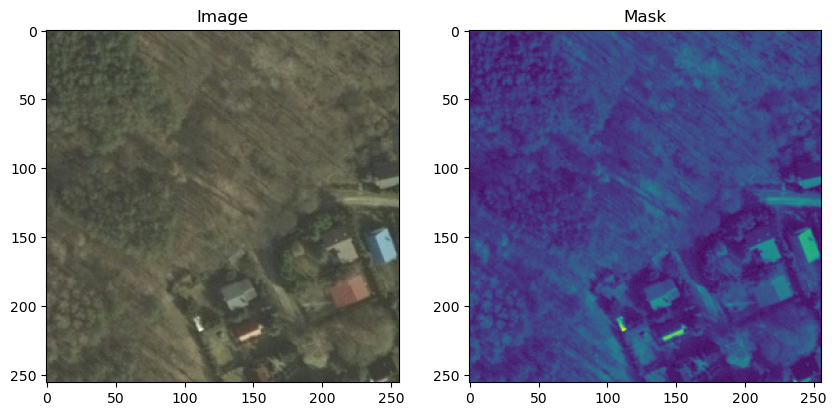

In [13]:
# Get paths of all images
img_files = list(dir_train_img.iterdir())

# Get random image from all images
img_path = random.choice(img_files)

# Plot with GPU support
# plot_image_and_mask(img_path, device="cuda")
plot_image_and_mask(img_path)

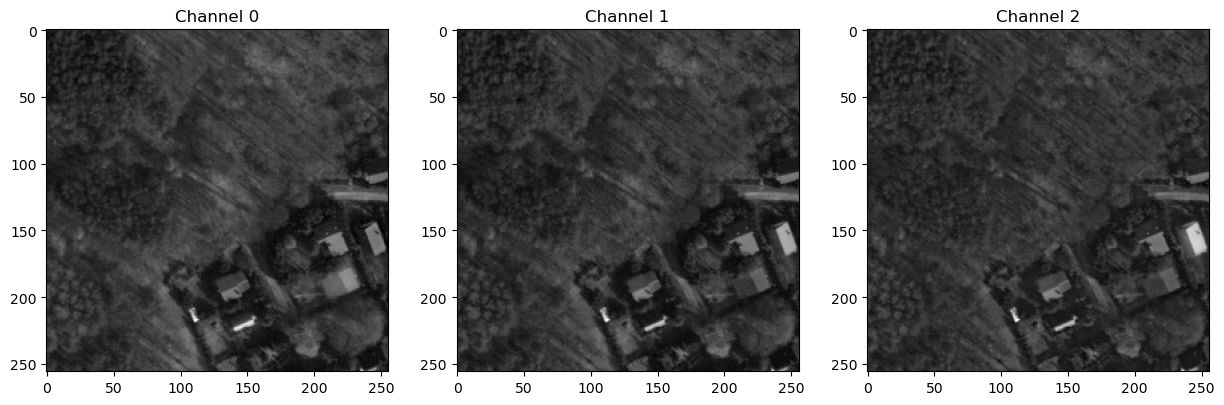

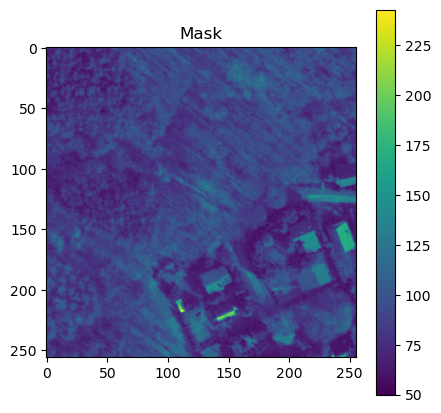

Moved image and mask to GPU


In [14]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Read the image correctly
temp_img = cv2.imread(str(img_path))  # Ensure it's read properly
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Plot each channel separately
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(temp_img[:, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i}")

plt.show()

# Read the mask (should be grayscale)
mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))
temp_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)  # Load as single-channel mask

if temp_mask is None:
    print(f"Error: Mask not found for {img_path}")
else:
    plt.figure(figsize=(5, 5))
    plt.imshow(temp_mask, cmap="viridis")
    plt.title("Mask")
    plt.colorbar()
    plt.show()

# Move to GPU if needed
if torch.cuda.is_available():
    temp_img_tensor = torch.tensor(temp_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    temp_mask_tensor = torch.tensor(temp_mask, dtype=torch.long).unsqueeze(0)

    temp_img_tensor = temp_img_tensor.to("cuda")
    temp_mask_tensor = temp_mask_tensor.to("cuda")

    print("Moved image and mask to GPU")





Image moved to GPU.


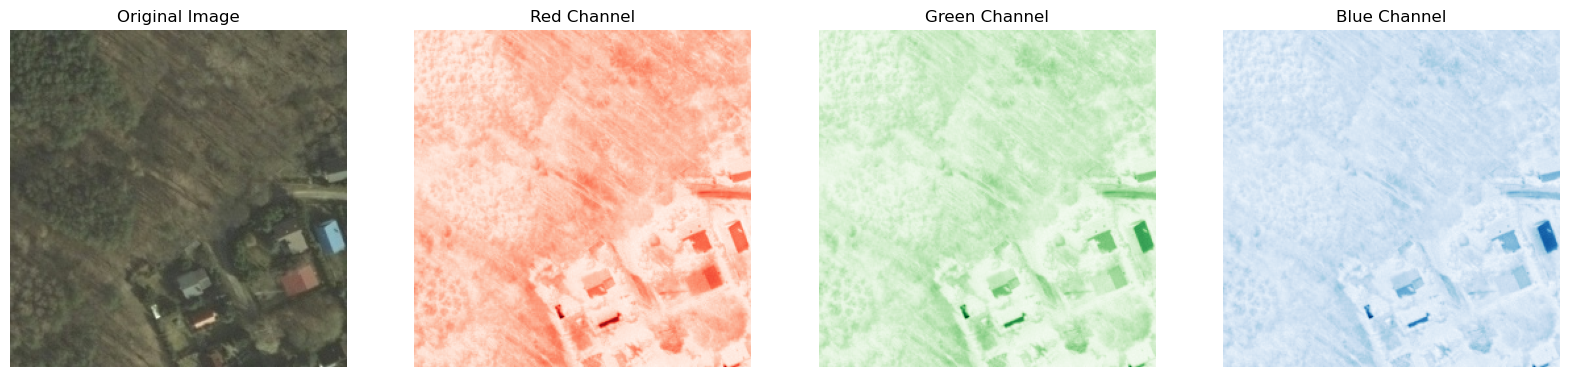

In [15]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_and_plot_image(img_path, device="cuda"):
    """
    Loads an image, splits RGB channels, and plots them with GPU support.
    """
    img_path = Path(img_path)  # Ensure it's a Path object

    # Load image safely
    img = cv2.imread(str(img_path))

    if img is None:
        print(f"Error: Image not found at {img_path}")
        return

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Split channels
    red_channel = img[:, :, 0]
    green_channel = img[:, :, 1]
    blue_channel = img[:, :, 2]

    # Convert to PyTorch tensor and move to GPU
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

    if torch.cuda.is_available():
        img_tensor = img_tensor.to(device)
        print("Image moved to GPU.")

    # Plot channels
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(red_channel, cmap="Reds")
    axs[1].set_title("Red Channel")
    axs[1].axis("off")

    axs[2].imshow(green_channel, cmap="Greens")
    axs[2].set_title("Green Channel")
    axs[2].axis("off")

    axs[3].imshow(blue_channel, cmap="Blues")
    axs[3].set_title("Blue Channel")
    axs[3].axis("off")

    plt.show()

# Example usage
load_and_plot_image(img_path)


In [16]:
import cv2
import torch
import numpy as np
from pathlib import Path

def analyze_mask(img_path, device="cuda"):
    """
    Loads the corresponding mask, checks unique labels, and moves to GPU if available.
    """
    img_path = Path(img_path)  # Ensure it's a Path object

    # Generate mask path dynamically
    mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

    if not mask_path.exists():
        print(f"Error: Mask not found for {img_path}")
        return

    # Load mask in grayscale mode
    temp_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if temp_mask is None:
        print(f"Error: Failed to load mask {mask_path}")
        return

    # Convert to PyTorch tensor and move to GPU
    mask_tensor = torch.tensor(temp_mask, dtype=torch.long).unsqueeze(0)  # Keep as long for segmentation

    if torch.cuda.is_available():
        mask_tensor = mask_tensor.to(device)
        print("Mask moved to GPU.")

    # Analyze unique labels and their counts
    labels, counts = np.unique(temp_mask, return_counts=True)

    print("Labels are:", labels)
    print("Counts are:", counts)

    return labels, counts

# Example usage
analyze_mask(img_path)


Mask moved to GPU.
Labels are: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 179 180 183 184 185 186 187 188 190 191 193 194 195 196 197 198
 200 201 202 203 204 205 206 207 212 215 217 224 225 238 241 243]
Counts are: [   1    1    3    1   12   22   31   68  106  180  270  338  499  620
  693  734  809  829  823  930  930  860  985 1053 1246 1275 1416 1445
 1566 1613 1791 1710 1748 1839 1832 1825 1860 1833 1881 1725 1636 1646
 1658 1744 1733 1698 1670 1527 1505 1436 1254 1202 1035  920  750  630
  571  553  450  413  3

(array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180,
        183, 184, 185, 186, 187, 188, 190, 191, 193, 194, 195, 196, 197,
        198, 200, 201, 202, 203, 204, 205, 206, 207, 212, 215, 217, 224,
        225, 238, 241, 243], dtype=uint8),
 array([   1,    1,    3,    1,   12,   22,   31,   68,  106,  180,  270,
       

### Define Generator for images and masks

In [17]:
import segmentation_models_pytorch as smp
import torch

# Set seed for reproducibility
seed = 24
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Define model parameters
batch_size = 16  # Lower to 8 if memory issues occur
n_classes = len(classes)
encoder_freeze = True

# Use DenseNet as the backbone
BACKBONE = "vgg19"

# PyTorch does not have `get_preprocessing()`, so we use transforms instead
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained="imagenet")

print(f"Using {BACKBONE} as backbone with {n_classes} classes.")


Using vgg19 as backbone with 5 classes.


In [18]:
print(n_classes)

5


In [19]:
import torch
import cv2
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from pathlib import Path

# Load an example image and mask
img_path = Path("../data/landcover_ai/train_images/train/M-34-65-D-a-4-4_patch_23_22.tif")
mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

if not img_path.exists() or not mask_path.exists():
    raise FileNotFoundError(f"Image or mask not found: {img_path}, {mask_path}")

# Load image (Assuming it's RGB)
img = cv2.imread(str(img_path))  # Reads as BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Load mask (Grayscale)
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

# Convert to numpy array
img = np.array(img, dtype=np.float32)  # Ensure float32 for normalization
mask = np.array(mask, dtype=np.int64)  # Ensure int64 for PyTorch one-hot encoding

# Define number of classes
num_class = 5  # Adjust based on your dataset

def preprocess_data(img, mask, num_class, device="cuda"):
    """
    Function to perform additional preprocessing after data augmentation.
    """
    # Convert to PyTorch tensor
    img = torch.tensor(img, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.long)  # Ensure long for one-hot encoding

    # Normalize images to [0, 1]
    img = img / 255.0  # Equivalent to MinMax scaling

    # Apply preprocessing function (Mean & Std from ImageNet)
    preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = preprocess(img.permute(2, 0, 1))  # Convert to (C, H, W) format

    # Check unique values in mask
    unique_values = torch.unique(mask)
    print(f"Unique mask values before one-hot: {unique_values}")

    # Ensure mask values are within range [0, num_class-1]
    if unique_values.max() >= num_class:
        print(f"Warning: Mask contains values greater than or equal to num_class ({num_class}). Clamping values.")
        mask = torch.clamp(mask, 0, num_class - 1)

    # Convert mask to one-hot encoding
    mask = F.one_hot(mask, num_classes=num_class).permute(2, 0, 1)  # (H, W) → (C, H, W)

    # Move to GPU if available
    if torch.cuda.is_available():
        img = img.to(device)
        mask = mask.to(device)

    return img, mask

# Apply preprocessing
img_tensor, mask_tensor = preprocess_data(img, mask, num_class)

print(f"Processed Image Shape: {img_tensor.shape}")  # Should be (3, H, W)
print(f"Processed Mask Shape: {mask_tensor.shape}")  # Should be (num_class, H, W)


Unique mask values before one-hot: tensor([ 26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 1

In [20]:
!pip install albumentations torch torchvision opencv-python  --quiet


import torch
import cv2
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import albumentations as A  # For augmentations
from albumentations.pytorch import ToTensorV2
import multiprocessing as mp


mp.set_start_method('spawn', force=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define augmentation transforms
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, num_class, transform=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.img_files = list(self.img_dir.glob("*.tif"))  # Adjust file extension if needed
        self.num_class = num_class
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

        # Load image
        img = cv2.imread(str(img_path))  # Reads as BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Load mask (grayscale)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Ensure correct datatype
        img = np.array(img, dtype=np.float32)  # Keep float32 for normalization
        mask = np.array(mask, dtype=np.int64)  # Ensure int64 for PyTorch one-hot

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]
            
        mask = np.clip(mask, 0, self.num_class - 1)

        # Convert mask to one-hot encoding
        mask = F.one_hot(torch.tensor(mask, dtype=torch.long), num_classes=self.num_class)
        mask = mask.permute(2, 0, 1)  # Convert to (C, H, W)

        return img, mask

# Define DataLoader function
# Define DataLoader function
def trainGenerator(train_img_path, train_mask_path, num_class, batch_size=16):
    dataset = SegmentationDataset(train_img_path, train_mask_path, num_class, transform=train_transforms)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)  # Fix: pin_memory=False
    return train_loader


# Example usage
train_loader = trainGenerator(dir_train_img,dir_train_mask,num_class=5)

# Get a batch
for img_batch, mask_batch in train_loader:
    img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)  # Ensure batch is on GPU
    print(f"Image batch shape: {img_batch.shape}")  # Should be (batch_size, 3, H, W)
    print(f"Mask batch shape: {mask_batch.shape}")  # Should be (batch_size, num_classes, H, W)
    break




Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 5, 256, 256])


C:\Users\xshay\AppData\Local\Temp\ipykernel_3636\2791591202.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = F.one_hot(torch.tensor(mask, dtype=torch.long), num_classes=self.num_class)


In [21]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import cv2
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, num_classes, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_paths = sorted(list(self.image_dir.glob("*.tif")))
        self.mask_paths = sorted(list(self.mask_dir.glob("*.tif")))
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image
        img = cv2.imread(str(self.image_paths[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # Normalize

        # Read mask
        mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE).astype(np.int64)

        # Convert mask to one-hot encoding
        mask = torch.as_tensor(mask, dtype=torch.long)
        mask = torch.nn.functional.one_hot(mask, num_classes=self.num_classes).permute(2, 0, 1)

        # Convert to PyTorch tensors
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        return img.to(device), mask.to(device)  # Move img & mask to GPU


In [22]:
from torch.utils.data import DataLoader
from pathlib import Path

# Define needed directory paths
DIRS = {
    "root": "../data/landcover_ai/",
    "train_img": "../data/landcover_ai/train_images/train/",
    "train_mask": "../data/landcover_ai/train_masks/train/",
    "val_img": "../data/landcover_ai/val_images/val/",
    "val_mask": "../data/landcover_ai/val_masks/val/"
}

# Convert to Pathlib objects
DIRS = {key: Path(value) for key, value in DIRS.items()}

# Check if directories contain files
for key, path in DIRS.items():
    if key not in ["root", "models"]:
        files = list(path.glob("*.tif"))
        print(f"{key} contains {len(files)} files")

# Create DataLoader for Training and Validation
train_loader = DataLoader(
    CustomDataset(DIRS["train_img"], DIRS["train_mask"], num_classes=n_classes),
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    CustomDataset(DIRS["val_img"], DIRS["val_mask"], num_classes=n_classes),
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

train_img contains 2250 files
train_mask contains 2250 files
val_img contains 750 files
val_mask contains 750 files


In [23]:
print(train_loader)
print(val_loader)

### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape (before argmax): torch.Size([16, 5, 256, 256])
Mask batch shape (after argmax): torch.Size([16, 256, 256])


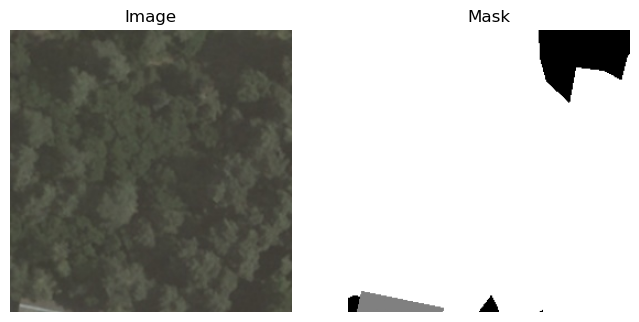

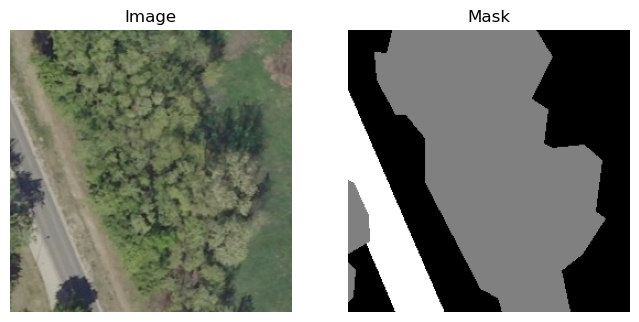

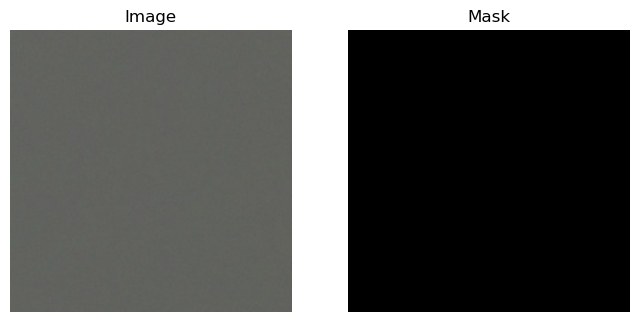

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Move device detection to the start
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fetch next batch (ensure pin_memory=False in DataLoader)
x, y = next(iter(train_loader))

# Move data to GPU after loading
x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long)

print(f"Image batch shape: {x.shape}")  # (batch_size, 3, height, width)
print(f"Mask batch shape (before argmax): {y.shape}")  # (batch_size, num_classes, height, width)

# Convert one-hot mask to categorical mask
if y.shape[1] > 1:  # Check if mask is one-hot encoded
    y = torch.argmax(y, dim=1)  # Convert to (batch_size, height, width)

print(f"Mask batch shape (after argmax): {y.shape}")  # (batch_size, height, width)

# Ensure x has 3 channels (RGB)
assert x.shape[1] == 3, "Expected 3 channels (RGB) in images"

# Ensure y has correct shape
assert len(y.shape) == 3, "Masks should have shape (batch_size, height, width)"

# Convert tensors to NumPy for visualization
x = x.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (batch_size, H, W, C)
y = y.cpu().numpy()  # Convert to (batch_size, H, W)

# Plot first 3 images and masks
for i in range(min(3, x.shape[0])):  # Ensure we don't go out of bounds
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(x[i])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(y[i], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()


Validation Image batch shape: torch.Size([16, 3, 256, 256])
Validation Mask batch shape (before argmax): torch.Size([16, 5, 256, 256])
Validation Mask batch shape (after argmax): torch.Size([16, 256, 256])


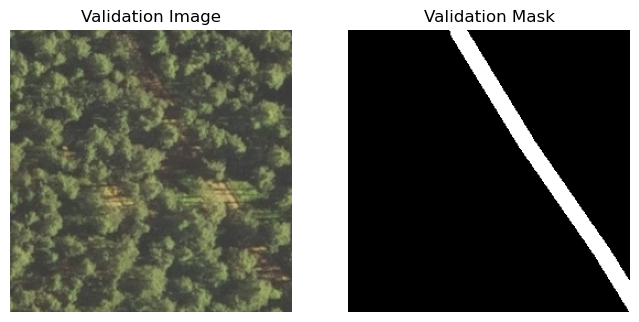

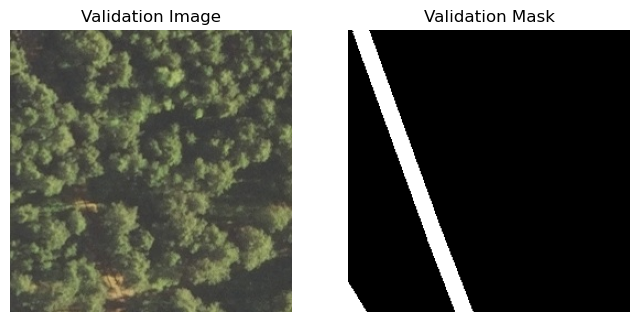

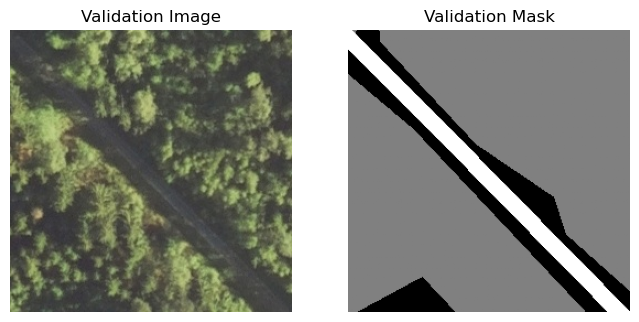

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Get the next batch of validation images and masks
x_val, y_val = next(iter(val_loader))

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_val, y_val = x_val.to(device), y_val.to(device)

print(f"Validation Image batch shape: {x_val.shape}")  # (batch_size, 3, H, W)
print(f"Validation Mask batch shape (before argmax): {y_val.shape}")  # (batch_size, num_classes, H, W)

# Convert one-hot mask to categorical labels
y_val = torch.argmax(y_val, dim=1)  # Now (batch_size, H, W)

print(f"Validation Mask batch shape (after argmax): {y_val.shape}")  # (batch_size, H, W)

# Ensure x_val has 3 channels (RGB)
assert x_val.shape[1] == 3, "Expected 3 channels (RGB) in images"

# Ensure y_val has correct shape
assert len(y_val.shape) == 3, "Masks should have shape (batch_size, height, width)"

# Plot the first 3 images and masks
for i in range(3):
    image = x_val[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    mask = y_val[i].cpu().numpy()  # Convert tensor to NumPy (H, W)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Validation Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Validation Mask")
    plt.axis("off")

    plt.show()


### Define the model metrics and load model

In [26]:
# Count the number of training and validation images
num_train_imgs = sum(1 for file in dir_train_img.iterdir() if file.is_file())
num_val_images = sum(1 for file in dir_val_img.iterdir() if file.is_file())

# Define batch size
batch_size = 16  # Adjust based on memory

# Compute steps per epoch
steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

# Extract image dimensions from a batch
sample_batch, _ = next(iter(train_loader))  # Get a sample batch from DataLoader

# Extract dimensions (PyTorch uses [batch_size, channels, height, width])
IMG_CHANNELS = sample_batch.shape[1]  # Channels (should be 3 for RGB)
IMG_HEIGHT = sample_batch.shape[2]  # Height
IMG_WIDTH = sample_batch.shape[3]  # Width



# Print results
print(f"Training Images: {num_train_imgs}, Validation Images: {num_val_images}")
print(f"Image Shape: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps_per_epoch}")


Training Images: 2250, Validation Images: 750
Image Shape: 256x256x3
Steps per epoch: 140, Validation steps: 46


In [27]:
# Number of training epochs
EPOCHS = 50

In [28]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [29]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
model = smp.Unet(
    encoder_name=BACKBONE,  # EfficientNet backbone
    encoder_weights="imagenet",  # Use pre-trained weights
    encoder_depth=5,
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=IMG_CHANNELS,  # 3 for RGB
    classes=len(classes),  # Number of output segmentation classes
    activation=None,  # No activation because we'll use CrossEntropyLoss
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function (using smp's Jaccard loss)
loss_fn = smp.losses.JaccardLoss(mode="multiclass")

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define IoU metric function
def iou_score(y_true, y_pred):
    """Compute IoU score using PyTorch."""
    intersection = (y_true & y_pred).float().sum((1, 2))  # Element-wise AND
    union = (y_true | y_pred).float().sum((1, 2))  # Element-wise OR
    return (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero

# Print model summary
print(model)

# Print input shape (PyTorch uses [batch_size, channels, height, width])
print(f"Model Input Shape: {IMG_CHANNELS}x{IMG_HEIGHT}x{IMG_WIDTH}")


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [30]:
!pip install torchviz torchinfo --quiet

In [31]:
from torchinfo import summary

# Print model architecture summary
summary(model, input_size=(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))


Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 5, 256, 256]          --
├─VGGEncoder: 1-1                             [1, 64, 256, 256]         --
│    └─Sequential: 2-1                        --                        --
│    │    └─Conv2d: 3-1                       [1, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                         [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                       [1, 64, 256, 256]         36,928
│    │    └─ReLU: 3-4                         [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                       [1, 128, 128, 128]        73,856
│    │    └─ReLU: 3-7                         [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                       [1, 128, 128, 128]        147,584
│    │    └─ReLU: 3-9                         [1, 128, 128, 128]        --
│   

In [32]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EarlyStopping:
    """Early stops the training if validation IoU does not improve after a given patience."""
    def __init__(self, patience=7, verbose=True, mode='max', delta=0.0001):
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score, model, path="best_model.pth"):
        score = val_score if self.mode == 'max' else -val_score

        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), path)  # Save best model
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=7, verbose=True, mode='max')




In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
import segmentation_models_pytorch as smp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name=BACKBONE,  
    encoder_weights="imagenet",  
    encoder_depth=5,
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=IMG_CHANNELS,
    classes=len(classes),  
    activation=None,
).to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Enable mixed precision
scaler = torch.amp.GradScaler('CUDA')

def train_one_epoch(model, train_loader, optimizer, criterion, device, accumulation_steps=2):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    total_batches = 0

    train_loader = tqdm(train_loader, total=min(len(train_loader), 500), desc="Training")
    optimizer.zero_grad()

    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(images)
            if masks.ndim == 4:
                masks = torch.argmax(masks, dim=1)
            loss = criterion(outputs, masks.long()) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:  
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        total_iou += compute_iou(outputs, masks)  
        total_batches += 1

        if i >= 500:
            break  # Limit training steps per epoch
        train_loader.set_description(f"Loss: {loss.item():.4f}")

    avg_loss = running_loss / total_batches
    avg_iou = total_iou / total_batches  
    return avg_loss, avg_iou 

# Validation Function
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, iou_scores = 0.0, []

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        if masks.ndim == 4:
            masks = torch.argmax(masks, dim=1)

        val_loss += criterion(outputs, masks.long()).item()
        iou_scores.append(compute_iou(outputs, masks))

    return val_loss / len(val_loader), sum(iou_scores) / len(iou_scores)

def compute_iou(outputs, masks):
    preds = torch.argmax(outputs, dim=1)  # Convert logits to class labels
    intersection = torch.logical_and(preds, masks).sum().item()
    union = torch.logical_or(preds, masks).sum().item()
    return intersection / (union + 1e-6)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience, self.counter, self.best_score, self.early_stop = patience, 0, None, False
        self.verbose = verbose

    def __call__(self, val_score, model, path="best_model.pth"):
        if self.best_score is None or val_score > self.best_score:
            self.best_score, self.counter = val_score, 0
            torch.save(model.state_dict(), path)
            if self.verbose: print(f"Model saved at {path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")

early_stopping = EarlyStopping()


# --- Initialize Metrics for Plotting ---
train_losses, val_losses = [], []
train_ious, val_ious = [], []

# --- Training Loop ---
for epoch in range(EPOCHS):
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou_score = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou_score)

    early_stopping(val_iou_score, model, path="best_model.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Train IoU: {train_iou:.4f} - Val IoU: {val_iou_score:.4f}")

    if early_stopping.early_stop:
        break

# Save Final Model
torch.save(model.state_dict(), f"final_model.pth")
print("Final model saved!")


Loss: 0.4267: 100%|██████████| 141/141 [00:47<00:00,  2.99it/s]


Model saved at best_model.pth
Epoch 1/50 - Train Loss: 0.6243 - Val Loss: 0.8078 - Train IoU: 0.6825 - Val IoU: 0.8428


Loss: 0.3417: 100%|██████████| 141/141 [02:10<00:00,  1.08it/s]


Model saved at best_model.pth
Epoch 2/50 - Train Loss: 0.3588 - Val Loss: 0.5275 - Train IoU: 0.8514 - Val IoU: 0.8710


Loss: 0.3225: 100%|██████████| 141/141 [02:10<00:00,  1.08it/s]


Model saved at best_model.pth
Epoch 3/50 - Train Loss: 0.2539 - Val Loss: 0.4271 - Train IoU: 0.8861 - Val IoU: 0.8769


Loss: 0.2085: 100%|██████████| 141/141 [02:06<00:00,  1.11it/s]


Model saved at best_model.pth
Epoch 4/50 - Train Loss: 0.2129 - Val Loss: 0.3634 - Train IoU: 0.8985 - Val IoU: 0.8919


Loss: 0.1791: 100%|██████████| 141/141 [02:07<00:00,  1.11it/s]


Model saved at best_model.pth
Epoch 5/50 - Train Loss: 0.1777 - Val Loss: 0.3290 - Train IoU: 0.9091 - Val IoU: 0.9011


Loss: 0.1186: 100%|██████████| 141/141 [02:09<00:00,  1.09it/s]


Epoch 6/50 - Train Loss: 0.1640 - Val Loss: 0.3260 - Train IoU: 0.9139 - Val IoU: 0.8912


Loss: 0.1699: 100%|██████████| 141/141 [02:11<00:00,  1.07it/s]


Model saved at best_model.pth
Epoch 7/50 - Train Loss: 0.1533 - Val Loss: 0.3167 - Train IoU: 0.9174 - Val IoU: 0.9031


Loss: 0.1386: 100%|██████████| 141/141 [02:09<00:00,  1.09it/s]


Epoch 8/50 - Train Loss: 0.1333 - Val Loss: 0.3040 - Train IoU: 0.9256 - Val IoU: 0.8922


Loss: 0.1414: 100%|██████████| 141/141 [02:11<00:00,  1.07it/s]


Model saved at best_model.pth
Epoch 9/50 - Train Loss: 0.1195 - Val Loss: 0.2774 - Train IoU: 0.9304 - Val IoU: 0.9082


Loss: 0.1448: 100%|██████████| 141/141 [02:12<00:00,  1.07it/s]


Epoch 10/50 - Train Loss: 0.1344 - Val Loss: 0.2801 - Train IoU: 0.9228 - Val IoU: 0.9052


Loss: 0.1638: 100%|██████████| 141/141 [02:12<00:00,  1.06it/s]


Epoch 11/50 - Train Loss: 0.1224 - Val Loss: 0.2735 - Train IoU: 0.9310 - Val IoU: 0.9031


Loss: 0.0884: 100%|██████████| 141/141 [02:10<00:00,  1.08it/s]


Model saved at best_model.pth
Epoch 12/50 - Train Loss: 0.1100 - Val Loss: 0.2720 - Train IoU: 0.9354 - Val IoU: 0.9105


Loss: 0.0918: 100%|██████████| 141/141 [02:06<00:00,  1.11it/s]


Epoch 13/50 - Train Loss: 0.0946 - Val Loss: 0.2641 - Train IoU: 0.9425 - Val IoU: 0.9079


Loss: 0.0625: 100%|██████████| 141/141 [02:06<00:00,  1.11it/s]


Model saved at best_model.pth
Epoch 14/50 - Train Loss: 0.0859 - Val Loss: 0.2561 - Train IoU: 0.9481 - Val IoU: 0.9128


Loss: 0.0624: 100%|██████████| 141/141 [02:06<00:00,  1.12it/s]


Epoch 15/50 - Train Loss: 0.0790 - Val Loss: 0.2813 - Train IoU: 0.9510 - Val IoU: 0.9113


Loss: 0.0972: 100%|██████████| 141/141 [02:06<00:00,  1.12it/s]


Epoch 16/50 - Train Loss: 0.0728 - Val Loss: 0.2616 - Train IoU: 0.9539 - Val IoU: 0.9124


Loss: 0.0534: 100%|██████████| 141/141 [02:06<00:00,  1.11it/s]


Epoch 17/50 - Train Loss: 0.0676 - Val Loss: 0.2613 - Train IoU: 0.9566 - Val IoU: 0.9114


Loss: 0.1169: 100%|██████████| 141/141 [02:06<00:00,  1.12it/s]


Epoch 18/50 - Train Loss: 0.1141 - Val Loss: 0.2743 - Train IoU: 0.9295 - Val IoU: 0.9012


Loss: 0.0861: 100%|██████████| 141/141 [02:06<00:00,  1.11it/s]


Early stopping triggered.
Epoch 19/50 - Train Loss: 0.0837 - Val Loss: 0.2588 - Train IoU: 0.9452 - Val IoU: 0.9066
Final model saved!


In [34]:
import torch
from pathlib import Path

# Save the final model
final_model_path = dir_models / f"final_{BACKBONE}_{EPOCHS}_model.pth"
torch.save(model.state_dict(), final_model_path)

print(f"Final model saved at: {final_model_path}")

Final model saved at: ..\data\models\final_vgg19_50_model.pth


In [35]:
'''from torchviz import make_dot
import torch

# Generate a random input tensor (batch size = 1)
sample_input = torch.randn(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH).to(device)

# Get model output
output = model(sample_input)

# Generate the computational graph
dot = make_dot(output, params=dict(model.named_parameters()))

# Save and display the model architecture
dot.format = "png"
dot.render("model_architecture")

# Display in notebook (if using Jupyter)
from IPython.display import Image
Image("model_architecture.png")
'''

'from torchviz import make_dot\nimport torch\n\n# Generate a random input tensor (batch size = 1)\nsample_input = torch.randn(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH).to(device)\n\n# Get model output\noutput = model(sample_input)\n\n# Generate the computational graph\ndot = make_dot(output, params=dict(model.named_parameters()))\n\n# Save and display the model architecture\ndot.format = "png"\ndot.render("model_architecture")\n\n# Display in notebook (if using Jupyter)\nfrom IPython.display import Image\nImage("model_architecture.png")\n'

### Plot training and validation IoU and loss at each epoch

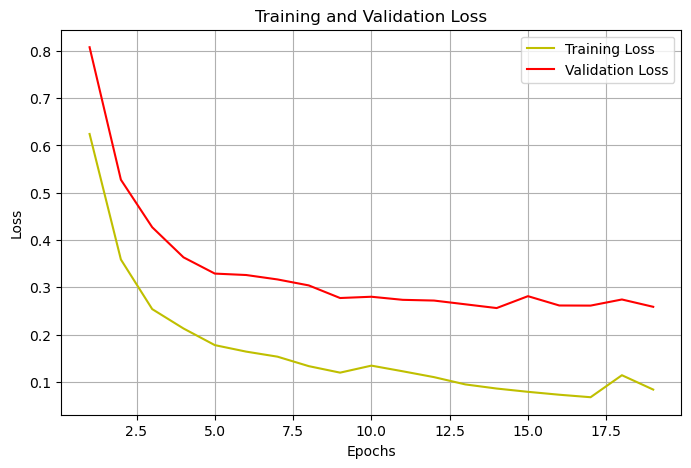

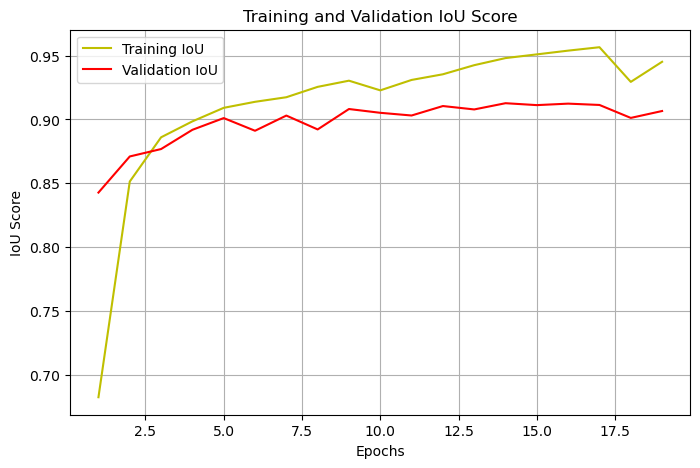

In [36]:
# --- Plot Training & Validation Metrics ---
epochs = list(range(1, len(train_losses) + 1))

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, "y", label="Training Loss")
plt.plot(epochs, val_losses, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation IoU
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_ious, "y", label="Training IoU")
plt.plot(epochs, val_ious, "r", label="Validation IoU")
plt.title("Training and Validation IoU Score")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.legend()
plt.grid()
plt.show()

### Evaulate model on test data

In [37]:
import torch
import numpy as np
from torchmetrics import JaccardIndex, Precision, Recall, F1Score
import segmentation_models_pytorch as smp

# Load saved model weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Define Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Get test batch
test_images, test_masks = next(iter(val_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Forward pass (Inference)
with torch.no_grad():
    test_preds = model(test_images)

# 🔹 Convert One-Hot Encoded Mask to Class Indices
if test_masks.ndim == 4:  # If shape is (B, C, H, W), convert to (B, H, W)
    test_masks = torch.argmax(test_masks, dim=1)

# Compute Validation Loss
loss = criterion(test_preds, test_masks)  # Now test_masks is (B, H, W)

# Convert predictions & masks to class indices
test_preds_argmax = torch.argmax(test_preds, dim=1)

# Ensure num_classes is an integer
num_classes = len(classes) if isinstance(classes, dict) else classes

# Initialize Metrics
iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

# Compute Metrics
iou_score = iou_metric(test_preds_argmax, test_masks)
precision = precision_metric(test_preds_argmax, test_masks)
recall = recall_metric(test_preds_argmax, test_masks)
f1_score = f1_metric(test_preds_argmax, test_masks)

# Print Results
print(f"Validation Loss = {loss.item():.4f}")
print(f"Mean IoU = {iou_score.item():.4f}")
print(f"Precision = {precision.item():.4f}")
print(f"Recall = {recall.item():.4f}")
print(f"F1-Score = {f1_score.item():.4f}")


C:\Users\xshay\AppData\Local\Temp\ipykernel_3636\3694834615.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locati

Validation Loss = 0.2928
Mean IoU = 0.7013
Precision = 0.8435
Recall = 0.7784
F1-Score = 0.8035


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [38]:
import torch
import torch.nn.functional as F
import numpy as np
from torchmetrics import Accuracy, MeanSquaredError

# Load trained model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Get test batch
test_images, test_masks = next(iter(val_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Forward pass (Inference)
with torch.no_grad():
    test_preds = model(test_images)

# Define number of classes properly
num_classes = len(classes) if isinstance(classes, dict) else classes

# Convert predictions & masks to class indices
test_preds_argmax = torch.argmax(test_preds, dim=1)  # (B, H, W)
test_masks_argmax = torch.argmax(test_masks, dim=1) if test_masks.ndim == 4 else test_masks  # (B, H, W)

# Compute Accuracy
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
accuracy = accuracy_metric(test_preds_argmax, test_masks_argmax)

# Compute Mean Squared Error (MSE)
mse_metric = MeanSquaredError().to(device)

# Convert `test_masks_argmax` to one-hot encoding and ensure contiguous memory
test_masks_one_hot = F.one_hot(test_masks_argmax, num_classes).permute(0, 3, 1, 2).contiguous().float()

# Ensure both tensors are in the same shape
mse = mse_metric(test_preds.float(), test_masks_one_hot.reshape_as(test_preds))

# Compute R-squared (R²) Score
y_true_flat = test_masks_argmax.cpu().numpy().flatten()  # Flatten ground truth
y_pred_flat = test_preds_argmax.cpu().numpy().flatten()  # Flatten predictions

if np.var(y_true_flat) == 0:  # Prevent division by zero
    r2 = 0.0
else:
    r2 = np.corrcoef(y_true_flat, y_pred_flat)[0, 1] ** 2  # R² using correlation

# Print metrics
print(f"Accuracy: {accuracy.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")
print(f"R² Score: {r2:.4f}")


C:\Users\xshay\AppData\Local\Temp\ipykernel_3636\26026370.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location

Accuracy: 0.9084
Mean Squared Error: 4.9097
R² Score: 0.4539


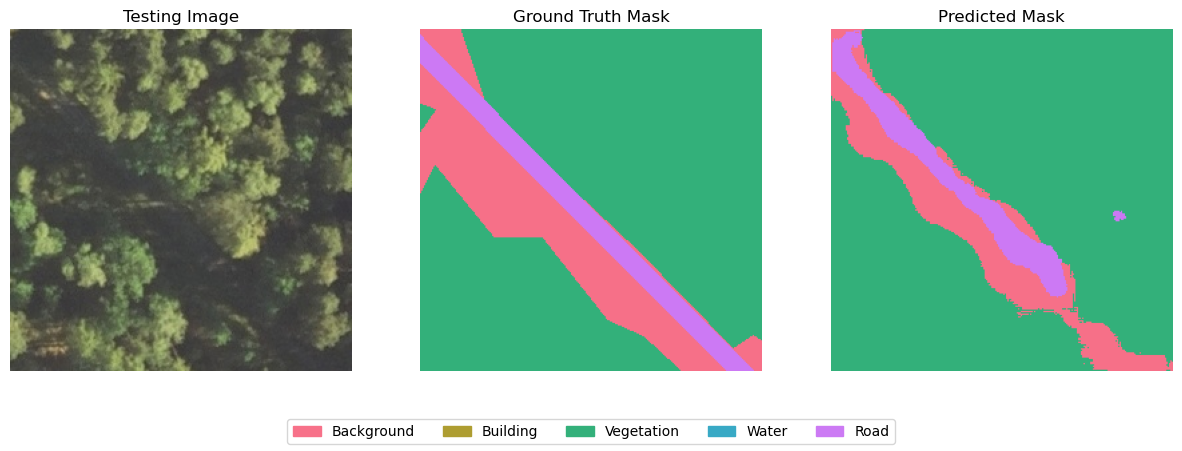

In [50]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches

# Define class labels and corresponding colors
class_labels = {
    0: "Background",
    1: "Building",
    2: "Vegetation",
    3: "Water",
    4: "Road",
}
num_classes = len(class_labels)

# Generate a consistent color palette
color_palette = sns.color_palette("husl", num_classes)  # Unique colors per class
class_colors = {k: np.array(v) for k, v in zip(class_labels.keys(), color_palette)}

# Function to colorize segmentation masks
def colorize_mask(mask):
    """Converts class-labeled mask into RGB color image"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3))  # Empty RGB image
    for cls_id, color in class_colors.items():
        color_mask[mask == cls_id] = color  # Apply class-specific colors
    return (color_mask * 255).astype(np.uint8)  # Convert to 0-255 range for display

# Get test batch
test_images, test_masks = next(iter(val_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Forward pass (Inference)
with torch.no_grad():
    test_preds = model(test_images)

# Convert predictions & ground truth to class indices
test_preds_argmax = torch.argmax(test_preds, dim=1).cpu().numpy()  # (B, H, W)
test_masks_argmax = torch.argmax(test_masks, dim=1).cpu().numpy() if test_masks.ndim == 4 else test_masks.cpu().numpy()  # (B, H, W)

# Select a random image
img_num = random.randint(0, test_images.shape[0] - 1)

# Convert tensor image to NumPy for visualization
test_image_np = test_images[img_num].cpu().numpy().transpose(1, 2, 0)  # (H, W, C)

# Convert masks to colorized versions
test_mask_color = colorize_mask(test_masks_argmax[img_num])
test_pred_color = colorize_mask(test_preds_argmax[img_num])

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(test_image_np)
axes[0].set_title("Testing Image")
axes[0].axis("off")

axes[1].imshow(test_mask_color)
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(test_pred_color)
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

# Create a legend
legend_patches = [mpatches.Patch(color=color_palette[i], label=class_labels[i]) for i in range(num_classes)]
fig.legend(handles=legend_patches, loc="lower center", ncol=num_classes, fontsize=10)

plt.show()
